#Setup

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Imports

In [66]:
import os
import time
import re
import time
import gc
from google.colab import files
import shutil

import numpy as np
import random
import math
import matplotlib.pyplot as plt

#Web
import urllib.request, json
import requests

#Images
from PIL import Image, ImageDraw
from IPython.display import display
from IPython.display import clear_output
import cv2

#Tensorflow
import tensorflow as tf
#tf.enable_eager_execution()
from tensorflow import keras
from __future__ import absolute_import, division, print_function

##Data Base

In [67]:
def generateDataBase():
    f= open('/content/drive/MyDrive/MTG/Modern.json','rb')
    data = json.load(f)
    # Creating dict to store unique words in cards, and map then to a number
    word_list = dict()
    subtype_list = dict()
    char_list = dict()
    card_number_listed = 0

    # Adding some special characters into the map
    word_list["[end]"] = len(word_list)
    word_list["[name]"] = len(word_list)
    word_list["[start]"] = len(word_list)
    word_list["[linebreak]"] = len(word_list)
    word_list["."] = len(word_list)
    word_list[","] = len(word_list)
    word_list[":"] = len(word_list)

    char_list["\n"] = 0

    # Iterating
    for collection in data['data']:
        for card in data['data'][collection]["cards"]:

            # Ignoring planeswalkers
            if "Planeswalker" in card["types"] or "Land" in card["types"]:
                continue
               
            if "text" in card:
                if "Level" in card["text"]:
                    continue
            
            # Split the text of the card into words, just to help the filter process,
            # it is also useful because we are going to map each single unique word into a table
            card_number_listed += 1
            textList = []

            # Add start code
            textList.append(word_list["[start]"])

            if "text" in card:

                # Adjusting string, to make sure intervals are regular and words are clean displayed
                string_text_linebreak = card["text"].replace(card["name"], " [name] ").replace("\n",
                                                                                               " [linebreak] ").replace(
                    ".", " . ").replace(":", " : ").replace(",", " , ").replace("\34", " \34 ").replace(";",
                                                                                                        " ; ").replace(
                    "(", " ( ").replace(")", " ) ").replace("—", " — ").replace("{T}", " {T} ").replace("{Q}", " {Q} ")

                # Cleaning MTG syntax
                string_text_linebreak.replace("remove from the game", " exile ")

                text = string_text_linebreak.split()

                # This variables is going to be used to ignore words inside ()
                ignore_italic = 0
                ignore_signal = ""

                for word in text:

                    # Ignoring italic text inside description
                    word = word.lower()

                    if "<" in word:
                        continue

                    if "{" in word:
                        if word != "{q}" and word != "{t}":
                            word = "[mana]"

                    if "/" in word:
                        if "+" in word[:1] or "-" in word[:1]:
                            word = "n/n"
                        else:
                            word = "p/t"

                    if "(" in word:
                        ignore_italic = 1

                    # Taking word in account
                    if ignore_italic == 0:

                        # Cleaning text
                        if word[-1:] == "." or word[-1:] == "," or word[-1:] == ":":
                            ignore_signal = word[-1:]
                            word = word[:-1]

                        # Final check
                        if len(word) > 0:
                            # Verify is word is unique, then add it
                            if word not in word_list:
                                word_list[word] = len(word_list)

                            # Add to list
                            textList.append(word_list[word])

                        # Verify if there is a signal
                        if len(ignore_signal) > 0:
                            textList.append(word_list[ignore_signal])
                            ignore_signal = ""

                    if ")" in word:
                        ignore_italic = 0
            else:
                card["text"] = ""

            textList.append(word_list["[end]"])
            card["textList"] = textList
                
            # Classifying subtype and adding it into card
            if "subtypes" in card:

                # Card has subtypes
                for sub in card["subtypes"]:

                    # See if the subtypes
                    if sub not in subtype_list:
                        subtype_list[sub] = []

                    # Apprend content
                    for c in card["colors"]:
                        if c not in subtype_list[sub]:
                            subtype_list[sub].append(c)
                    for cardtype in card["types"]:
                        if cardtype not in subtype_list[sub]:
                            subtype_list[sub].append(cardtype)
            else:
                # Card has no subtype
                card["subList"].append(0)

            # Classifying characters in text
            if "name" in card:

                # Split the text of the card into words, just to help the filter process,
                # it is also useful because we are going to map each single unique word into a table
                textList = []

                # Get Title
                title = card["name"]
                for char in title:
                    
                    if (char.isalpha() or char.isspace() or char == "\'"):
                        # Verify is char is unique, then add it
                        if char not in char_list:
                            char_list[char] = len(char_list)

                        # Add to list
                        textList.append(char_list[char])

                textList.append(char_list["\n"])
                card["titleList"] = textList
                
                # Forcing colors into land types, it makes easier to the system to classify a land based own its color features
                if title == "Plains":
                    card["colors"] += "w"
                elif title == "Mountain":
                    card["colors"] += "r"
                elif title == "Swamp":
                    card["colors"] += "b"
                elif title == "Forest":
                    card["colors"] += "g"
                elif title == "Island":
                    card["colors"] += "u"
                
    # Creating reverse table for words
    list_to_word = []

    for key in word_list:
        list_to_word.append(key)

    list_to_word = np.array(list_to_word)

    # Creating reverse table for words
    list_to_char = []

    for key in char_list:
        list_to_char.append(key)

    list_to_char = np.array(list_to_char)

    # Priting info
    print("Total number of unique words: " + str(len(word_list)))
    print("Total number of unique subtypes: " + str(len(subtype_list)))
    print("Total number of unique chars: " + str(len(char_list)))
    print("Among " + str(card_number_listed) + " cards listed.")

    # Saving Files
    with open('cardbase.json', 'w') as outfile:
        json.dump(data, outfile)

    with open('list_to_subs.dat', 'w') as outfile:
        json.dump(subtype_list, outfile)
        
    np.save("list_to_word", list_to_word)
    np.save("list_to_char", list_to_char)

In [68]:
generateDataBase()#https://mtgjson.com/downloads/all-files/


Total number of unique words: 2053
Total number of unique subtypes: 229
Total number of unique chars: 59
Among 17777 cards listed.


##Getters

In [69]:
def getCardbase():

    if not os.path.exists("cardbase.json"):
        generateDataBase()

    with open('cardbase.json') as json_file:
        data = json.load(json_file)

    return data

In [70]:
def getList():

    if not os.path.exists("list_to_word.npy"):
        generateDataBase()

    list_to_word = np.load("list_to_word.npy")
    return list_to_word

In [71]:
def getListTitle():

    if not os.path.exists("list_to_char.npy"):
        generateDataBase()

    list_to_word = np.load("list_to_char.npy")
    return list_to_word

In [72]:
def getListSubs():

    if not os.path.exists("list_to_subs.dat"):
        generateDataBase()

    list_to_word = json.load( open('list_to_subs.dat',"r"))
    return list_to_word

In [73]:
def getListWords():
    
    #Get Dict data
    list_to_word = getList();

    #Wordlist
    word_list = dict();
    i = 0
    
    for pos in list_to_word:
        word_list[pos] = i
        i += 1
        
    return word_list

In [74]:
def getListTitleWords():
    
    #Get Dict data
    list_to_word = getListTitle();

    #Wordlist
    word_list = dict();
    i = 0
    
    for pos in list_to_word:
        word_list[pos] = i
        i += 1
        
    return word_list

##Utility

In [75]:
def decodeCardList(arraydesc):

    #New Desc
    newdescription = ""

    #Get Dict data
    list_to_word = getList();
    word_list = getListWords();

    up_next = 1
    
    #Iterate
    for idx,i in enumerate(arraydesc):
        if i != word_list["[end]"] and i != word_list["[start]"] and i != word_list["[linebreak]"]:

            if i != word_list["."] and i != word_list[","] and i != word_list[":"] and arraydesc[max( 0, idx - 1)] != word_list["[linebreak]"]:
                newdescription += " "

            if i == word_list["."] or i == word_list[":"] or i == word_list["•"]:
                up_next = 1
                
            if not (i == word_list["."] and newdescription[:-1] != "."):
                if up_next == 1 and i != word_list["."]:
                    
                    newdescription += list_to_word[i].capitalize()
                    up_next = 0
                    
                else:
                    newdescription += list_to_word[i]

        elif i == word_list["[end]"]:
            if newdescription[:-1] != ".":
                newdescription += "."
                
            up_next = 1  
            
            break
            
        elif i == word_list["[linebreak]"]:
            if newdescription[:-1] != ".":
                newdescription += "."
                
            up_next = 1
            newdescription += "\n"

    #Check len
    newdescription = newdescription.strip()
    
    if len(newdescription) < 2:
        newdescription = ""
    
    #Replace some keywords
    newdescription = newdescription.replace("[name]","~")
    
    return newdescription

In [76]:
def decodeCardTitle(arraydesc):

    #New Desc
    newdescription = ""

    #Get Dict data
    list_to_word = getListTitle();
    word_list = getListTitleWords();

    #Iterate
    for i in arraydesc:
        if i == word_list["\n"] and len(newdescription) > 2:
            break
        else:
            newdescription += list_to_word[i]
            
    #Upper and lower
    newdescription = list(newdescription.strip())
    for idx,c in enumerate(newdescription):
        if idx == 0 or newdescription[ max(0, idx - 1)] == " ":
            newdescription[idx] = c.upper()
        else:
            newdescription[idx] = c.lower()
            
    #Return Description
    return "".join(newdescription)

In [77]:
def findCard( name):

    # Get cardbase
    data = getCardbase()
    
    # Search
    for collection in data:
        for card in data[collection]["cards"]:
            if card["name"] == name:
                return card
            
    return None;
    

In [78]:
def plotCla( history):
    
    # Plotting accuracy for classifier models
    history_dict = history.history
    print( history_dict.keys())

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vbin = history_dict['binary_crossentropy']
    val_vbin = history_dict['val_binary_crossentropy']

    epochs = range(1, len(acc) + 1)
    
    clear_output()
    
    ###
    # Figure
    plt.figure(figsize=(10,4))
    plt.clf()   # clear figure
    
    plt.plot(epochs, vbin, 'bo', label='Baseline train')
    plt.plot(epochs, val_vbin, 'b', label='Baseline val')
    plt.title('Binary Crossentropy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
    ###
    #Second graph
    plt.figure(figsize=(10,4))
    plt.clf()   # clear figure
    
    plt.plot(epochs, acc, 'yo', label='Acc train')
    plt.plot(epochs, val_acc, 'y', label='Acc val')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
    del history
    gc.collect()

#Description Generator

##Dataset

In [79]:
def DesGen_data():

    # Concatenate all data
    concatened_text = []
    data = getCardbase()

    for collection in data['data']:
        for card in data['data'][collection]["cards"]:
            if "textList" in card:
                for element in card["textList"]:
                    concatened_text.append(element)

    concatened_text = np.array(concatened_text)
    return concatened_text

In [80]:
def split_input_target(chunk):

    input_text = chunk[:-1]
    target_text = chunk[1:]

    return input_text, target_text

##Model

In [81]:
def DesGen_build_model(batch_size):

    # input shape is the vocabulary
    vocab_size = len(getList())
    
    # The embedding dimension
    embedding_dim = 128

    # Number of RNN units
    rnn_units = 850
    
    # Building the model structure
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                             return_sequences=True,
                             recurrent_initializer='glorot_uniform',
                             stateful=True),
        tf.keras.layers.Dense(vocab_size)
    ])

    return model

In [82]:
def DesGen_build():

    # Preparing data
    list_to_word = getList()
    concatened_text = DesGen_data()

    # The maximum length sentence we want for a single input in characters
    seq_length = 35
    examples_per_epoch = len(concatened_text) // seq_length

    # Create training examples / targets
    char_dataset = tf.data.Dataset.from_tensor_slices(concatened_text)
    sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

    # Split target data
    dataset = sequences.map(split_input_target)

    # Batch size
    BATCH_SIZE = 64
    steps_per_epoch = examples_per_epoch // BATCH_SIZE

    BUFFER_SIZE = 10000
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

    # Building model
    model = DesGen_build_model(batch_size=BATCH_SIZE)

    def loss(labels, logits):
        return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

    model.compile(
        optimizer=tf.optimizers.Adam(),
        loss=loss)

    # Directory where the checkpoints will be saved
    checkpoint_dir = './training_checkpoints/DescriptionGenerator'
    # Name of the checkpoint files
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_prefix,
        save_weights_only=True)

    # Training
    EPOCHS = 100
    history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback], verbose=1)

In [83]:
DesGen_build()

Epoch 1/100
180/180 [==============================] - 15s 71ms/step - loss: 4.2870
Epoch 2/100
180/180 [==============================] - 13s 70ms/step - loss: 2.4371
Epoch 3/100
180/180 [==============================] - 13s 71ms/step - loss: 1.9614
Epoch 4/100
180/180 [==============================] - 13s 71ms/step - loss: 1.7451
Epoch 5/100
180/180 [==============================] - 13s 70ms/step - loss: 1.6189
Epoch 6/100
180/180 [==============================] - 13s 70ms/step - loss: 1.5268
Epoch 7/100
180/180 [==============================] - 13s 70ms/step - loss: 1.4614
Epoch 8/100
180/180 [==============================] - 13s 71ms/step - loss: 1.4045
Epoch 9/100
180/180 [==============================] - 13s 71ms/step - loss: 1.3586
Epoch 10/100
180/180 [==============================] - 13s 71ms/step - loss: 1.3225
Epoch 11/100
180/180 [==============================] - 13s 71ms/step - loss: 1.2872
Epoch 12/100
180/180 [==============================] - 13s 71ms/step - lo

##Generating

In [84]:
def predictDescription():

    # Preparing data
    list_to_word = getList()

    # Directory where the checkpoints will be saved
    checkpoint_dir = './training_checkpoints/DescriptionGenerator'
    #tf.train.latest_checkpoint(checkpoint_dir)

    # Load
    model = DesGen_build_model(batch_size=1)
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    model.build(tf.TensorShape([1, None]))

    # Number of characters to generate
    num_generate = 110

    # Converting our start string to numbers (vectorizing)
    start_code = [ getListWords()["[start]"]]
    input_eval = start_code
    input_eval = tf.expand_dims(input_eval, 0)

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.9

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a multinomial distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.compat.v1.multinomial(predictions, num_samples=1)[-1, 0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        start_code.append(predicted_id)
        
        #Check end
        if predicted_id == 0:
            break
            
    del model
    gc.collect()

    return (start_code)

In [85]:
desc = predictDescription()
print("CARD DESCRIPTION")
print()
print( decodeCardList(desc))

CARD DESCRIPTION

Waif additional n/n until end of turn.
Whenever a creature you control dies, each other player sacrifices a creature.


#Color Classifier

##Dataset

In [86]:
def ColCla_data( percent):

    # Declaring data
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    
    # Concatenate all data
    data = getCardbase()

    # Split info
    i = 0
    
    # Iterate
    for collection in data['data']:
        for card in data['data'][collection]["cards"]:
            if "textList" in card:
                
                # Deciding which array
                i += 0.1
                
                if i <= percent:
                    test = 0
                else:
                    test = 1
                    if i >= 0.99:
                        i = 0
                
                # Add to data
                if test == 0:
                    train_data.append( card["textList"])
                else:
                    test_data.append( card["textList"])
                    
                # Define label
                color = [0] * 5
                if "W" in card["colors"]:
                    color[0] = 1
                if "U" in card["colors"]:
                    color[1] = 1
                if "B" in card["colors"]:
                    color[2] = 1
                if "R" in card["colors"]:
                    color[3] = 1
                if "G" in card["colors"]:
                    color[4] = 1
                
                if test == 0:
                    train_labels.append(color)
                else:
                    test_labels.append(color)
                    
    #Shuffle
    shuffledata = list(zip(train_data, train_labels))
    train_data, train_labels = zip(*shuffledata)

    #Return
    return train_data, train_labels, test_data, test_labels

##Model

In [87]:
def ColCla_build_model():
    
    # input shape is the vocabulary
    vocab_size = len(getList())

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 16))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(5, activation=tf.nn.sigmoid))

    return model

In [88]:
def ColCla_build():
    
    # Get Data and split it
    percent = 0.9   
    request_data = ColCla_data( percent)
    
    train_data = request_data[0]
    train_label = request_data[1]
    test_data = request_data[2]
    test_label = request_data[3]
    
    # Converting data
    MAX_CARD_DESC_LENGTH = 70
    
    train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=MAX_CARD_DESC_LENGTH)
    
    train_label = tf.keras.preprocessing.sequence.pad_sequences(train_label)

    test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data,
                                                           value=0,
                                                           padding='post',
                                                           maxlen=MAX_CARD_DESC_LENGTH)
    
    test_label = tf.keras.preprocessing.sequence.pad_sequences(test_label)
    
    # Build the model and prepare it for training
    model = ColCla_build_model()
    model.compile(optimizer=tf.optimizers.Adam(),
              loss='binary_crossentropy',
                 metrics=["accuracy", "binary_crossentropy"])
    
    # Directory where the checkpoints will be saved
    checkpoint_dir = './training_checkpoints/ColorClassifier'
    # Name of the checkpoint files
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_prefix,
        save_weights_only=True)
    
    # Train the model
    history = model.fit(train_data,
                    train_label,
                    epochs=48,
                    batch_size=64,
                    validation_data=(test_data, test_label),
                    verbose=1, callbacks=[checkpoint_callback])
    
    # Plot Graph
    plotCla( history)

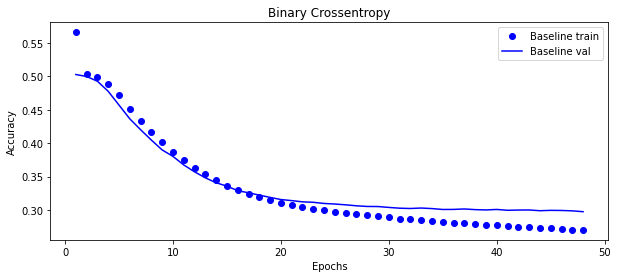

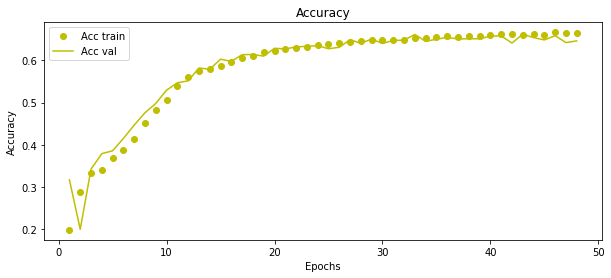

In [89]:
ColCla_build()

##Generating

In [90]:
def predictColor( feed, print_info=0):

    # Directory where the checkpoints will be saved
    checkpoint_dir = './training_checkpoints/ColorClassifier'

    # Load
    model = ColCla_build_model()
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    model.build(tf.TensorShape([1, None]))

    # Predict
    arrayfeed = []
    arrayfeed.append( feed)
    feed = keras.preprocessing.sequence.pad_sequences( arrayfeed, value=0, padding='post', maxlen=70)
    
    prediction = model.predict( feed)[0]
    color = ""
    
    # Compose string
    threshhold = 0.25
    
    if prediction[0] > threshhold:
        color += "W"
    if prediction[1] > threshhold:
        color += "U"
    if prediction[2] > threshhold:
        color += "B"
    if prediction[3] > threshhold:
        color += "R"
    if prediction[4] > threshhold:
        color += "G"
    
    # Additional information
    if print_info == 1:
        for idx,val in enumerate(prediction):
            prediction[idx] = math.floor(val * 1000) * 0.001
            
        print( "W: " + str(prediction[0]))
        print( "U: " + str(prediction[1]))
        print( "B: " + str(prediction[2]))
        print( "R: " + str(prediction[3]))
        print( "G: " + str(prediction[4]))
        print()
        
    del model
    gc.collect()
    
    # Return
    return color,prediction
    

In [91]:
desc = predictDescription()
print("CARD DESCRIPTION")
print()
print( decodeCardList(desc))
print()
print( "Color: " + str( predictColor( desc, 1)[0] ))

CARD DESCRIPTION

Mysterious look at the top two cards of that library You choose a nonland card from it with flying " then it fights those permanent they control with trample.

W: 0.015
U: 0.564
B: 0.019
R: 0.28
G: 0.417

Color: URG


#Type Classifier

##Dataset

In [92]:
def TypCla_data( percent):

    # Declaring data
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    
    # Concatenate all data
    data = getCardbase()

    # Split info
    i = 0
    
    # Iterate
    for collection in data['data']:
        for card in data['data'][collection]["cards"]:
            if "textList" in card:
                
                # Deciding which array
                i += 0.1
                
                if i <= percent:
                    test = 0
                else:
                    test = 1
                    if i >= 0.99:
                        i = 0
                
                # Add to data
                if test == 0:
                    train_data.append( card["textList"])
                else:
                    test_data.append( card["textList"])
                    
                # Define label
                typecard = [0] * 6
                listtypes = card["types"]
                
                if "Enchantment" in card["type"]:
                    typecard[0] = 1
                if "Artifact" in card["type"]:
                    typecard[1] = 1
                if "Land" in card["type"]:
                    typecard[2] = 1
                if "Instant" in card["type"]:
                    typecard[3] = 1
                if "Sorcery" in card["type"]:
                    typecard[4] = 1
                if "Creature" in card["type"]:
                    typecard[5] = 1
                
                if test == 0:
                    train_labels.append(typecard)
                else:
                    test_labels.append(typecard)

    #Shuffle
    shuffledata = list(zip(train_data, train_labels))
    train_data, train_labels = zip(*shuffledata)

    #Return
    return train_data, train_labels, test_data, test_labels

##Model

In [93]:
def TypCla_build_model():
    
    # input shape is the vocabulary
    vocab_size = len(getList())

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 16))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(6, activation=tf.nn.sigmoid))
    
    return model

In [94]:
def TypCla_build():
    
    # Get Data and split it
    percent = 0.9   
    request_data = TypCla_data( percent)
    
    train_data = request_data[0]
    train_label = request_data[1]
    test_data = request_data[2]
    test_label = request_data[3]
    
    # Converting data
    MAX_CARD_DESC_LENGTH = 70
    
    train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=MAX_CARD_DESC_LENGTH)
    
    train_label = tf.keras.preprocessing.sequence.pad_sequences(train_label)

    test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data,
                                                           value=0,
                                                           padding='post',
                                                           maxlen=MAX_CARD_DESC_LENGTH)
    
    test_label = tf.keras.preprocessing.sequence.pad_sequences(test_label)
    
    # Build the model and prepare it for training
    model = TypCla_build_model()
    model.compile(optimizer=tf.optimizers.Adam(),
              loss='binary_crossentropy',
                 metrics=["accuracy", "binary_crossentropy"])
    
    # Directory where the checkpoints will be saved
    checkpoint_dir = './training_checkpoints/TypeClassifier'
    # Name of the checkpoint files
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_prefix,
        save_weights_only=True)
    
    # Train the model
    history = model.fit(train_data,
                    train_label,
                    epochs=48,
                    batch_size=64,
                    validation_data=(test_data, test_label),
                    verbose=1, callbacks=[checkpoint_callback])
    
    # Plot Graph
    plotCla( history)

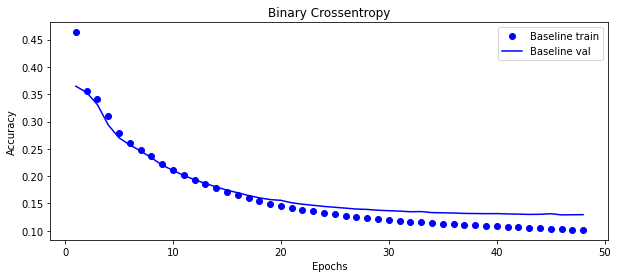

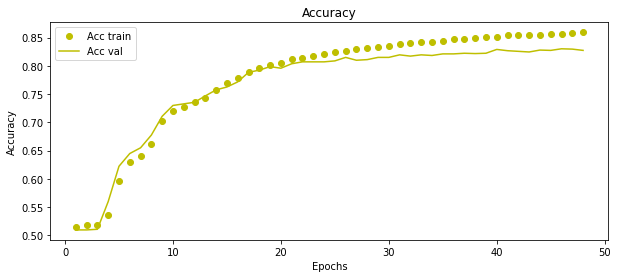

In [95]:
TypCla_build()

##Generating

In [96]:
def predictType( feed, print_info=0):
    
    # Directory where the checkpoints will be saved
    checkpoint_dir = './training_checkpoints/TypeClassifier'

    # Load
    model = TypCla_build_model()
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    
    # Predict
    arrayfeed = []
    arrayfeed.append( feed)
    feed = tf.keras.preprocessing.sequence.pad_sequences( arrayfeed, value=0, padding='post', maxlen=70)
    
    prediction = model.predict( feed)[0]
    typecard = ""
    
    # Compose string
    threshhold = 0.415
    highest_index = np.argmax(prediction)
    
    # Avoid conflict
    ##### ERRROR
    if highest_index == 0 or prediction[0] > threshhold:
        typecard += "Enchantment "
    if highest_index == 1 or (prediction[1] > threshhold and not (highest_index == 3 or highest_index == 4)):
        typecard += "Artifact "
    if highest_index == 2 or prediction[2] > threshhold and not (highest_index == 3 or highest_index == 4):
        typecard += "Land "
    if (highest_index == 3 or (prediction[3] > threshhold and not (highest_index == 4))) and not highest_index == 5 and not "Artifact" in typecard and not "Land" in typecard:
        typecard += "Instant "
    if (highest_index == 4 or (prediction[4] > threshhold and not (highest_index == 3))) and not highest_index == 5 and not "Artifact" in typecard and not "Land" in typecard:
        typecard += "Sorcery "
    if highest_index == 5 or prediction[5] > threshhold:
        typecard += "Creature "
    
    # Additional information
    if print_info == 1:
        for idx,val in enumerate(prediction):
            prediction[idx] = math.floor(val * 1000) * 0.001
            
        print( "Enchantment: " + str(prediction[0]))
        print( "Artifact   : " + str(prediction[1]))
        print( "Land       : " + str(prediction[2]))
        print( "Instant    : " + str(prediction[3]))
        print( "Sorcery    : " + str(prediction[4]))
        print( "Creature   : " + str(prediction[5]))
        print()

    del model
    gc.collect()
        
    # Return
    return typecard.strip()
    

In [97]:
desc = predictDescription()
print("CARD DESCRIPTION")
print()
print( decodeCardList(desc))
print()
print( "Type: " + str( predictType( desc, 1)))

CARD DESCRIPTION

Rats 4.

Enchantment: 0.004
Artifact   : 0.027
Land       : 0.0
Instant    : 0.0
Sorcery    : 0.001
Creature   : 0.997

Type: Creature


#Title Generator

##Dataset

In [98]:
def TilGen_data():

    # Concatenate all data
    concatened_text = []
    data = getCardbase()

    for collection in data['data']:
        for card in data['data'][collection]["cards"]:
            if "titleList" in card:
                for element in card["titleList"]:
                    concatened_text.append(element)

    concatened_text = np.array(concatened_text)
    return concatened_text

##Model

In [99]:
def TilGen_build_model(batch_size):

    # Preparing data
    list_to_word = getListTitle()
    
    # input shape is the vocabulary
    vocab_size = len(list_to_word)
    
    # The embedding dimension
    embedding_dim = 128

    # Number of RNN units
    rnn_units = 850
    
    # Building the model structure
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                             return_sequences=True,
                             recurrent_initializer='glorot_uniform',
                             stateful=True),
        tf.keras.layers.Dense(vocab_size)
    ])

    return model

In [100]:
def TilGen_build():

    # Preparing data
    list_to_word = getListTitle()
    concatened_text = TilGen_data()

    # The maximum length sentence we want for a single input in characters
    seq_length = 55
    examples_per_epoch = len(concatened_text) // seq_length
    
    # Create training examples / targets
    char_dataset = tf.data.Dataset.from_tensor_slices(concatened_text)
    sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

    # Split target data
    dataset = sequences.map(split_input_target)

    # Batch size
    BATCH_SIZE = 64
    steps_per_epoch = examples_per_epoch // BATCH_SIZE

    BUFFER_SIZE = 10000
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

    # Building model
    model = TilGen_build_model(batch_size=BATCH_SIZE)

    def loss(labels, logits):
        return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

    model.compile(
        optimizer=tf.optimizers.Adam(),
        loss=loss)

    # Directory where the checkpoints will be saved
    checkpoint_dir = './training_checkpoints/TitleGenerator'
    # Name of the checkpoint files
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_prefix,
        save_weights_only=True)

    # Training
    EPOCHS = 90
    model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

In [101]:
TilGen_build()

Epoch 1/90
84/84 [==============================] - 9s 84ms/step - loss: 3.2407
Epoch 2/90
84/84 [==============================] - 7s 83ms/step - loss: 2.5291
Epoch 3/90
84/84 [==============================] - 7s 83ms/step - loss: 2.3415
Epoch 4/90
84/84 [==============================] - 7s 83ms/step - loss: 2.2437
Epoch 5/90
84/84 [==============================] - 7s 83ms/step - loss: 2.1616
Epoch 6/90
84/84 [==============================] - 7s 83ms/step - loss: 2.0703
Epoch 7/90
84/84 [==============================] - 7s 83ms/step - loss: 1.9730
Epoch 8/90
84/84 [==============================] - 7s 83ms/step - loss: 1.8648
Epoch 9/90
84/84 [==============================] - 7s 83ms/step - loss: 1.7611
Epoch 10/90
84/84 [==============================] - 7s 83ms/step - loss: 1.6615
Epoch 11/90
84/84 [==============================] - 7s 83ms/step - loss: 1.5709
Epoch 12/90
84/84 [==============================] - 7s 83ms/step - loss: 1.4878
Epoch 13/90
84/84 [==================

##Generating

In [102]:
def predictTitle():

    # Preparing data
    list_to_word = getListTitle()

    # Directory where the checkpoints will be saved
    checkpoint_dir = './training_checkpoints/TitleGenerator'
    #tf.train.latest_checkpoint(checkpoint_dir)

    # Load
    model = TilGen_build_model(batch_size=1)
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    model.build(tf.TensorShape([1, None]))

    # Number of characters to generate
    num_generate = 20

    # Converting our start string to numbers (vectorizing)
    listtitle_words = getListTitleWords()
    
    starting_list_options = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","X","W","Y","Z"]
    start_code = [ listtitle_words["\n"], listtitle_words[random.choice(starting_list_options)]]
    input_eval = start_code
    input_eval = tf.expand_dims(input_eval, 0)

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.95

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a multinomial distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.compat.v1.multinomial(predictions, num_samples=1)[-1, 0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        start_code.append(predicted_id)
        
    del model
    gc.collect()
        
    return start_code

In [103]:
def predictTitleDecoded():
    
    #Request title
    requestTitle = decodeCardTitle( predictTitle())
    
    #Acess data base,
    data = getCardbase()
    
    does_not_exist = True
    
    for collection in data['data']:
        for card in data['data'][collection]["cards"]:
            if card["name"].lower() == requestTitle.lower():
                does_not_exist = False
                break
                
    if does_not_exist == False:
        return predictTitleDecoded()
    else:
        return requestTitle


In [104]:
title = predictTitleDecoded()
print("CARD TITLE")
print()
print( title)

CARD TITLE

Asha's Familiar


#Assembler

##Utility

In [105]:
def suggestCost( desc):
    
    #Import
    import difflib
    
    #Data and wordlist
    data = getCardbase()
    word_list = getListWords()
    smmax = 0
    costmatch = 0
    
    # Iterate
    for collection in data['data']:
        for card in data['data'][collection]["cards"]:
            if "textList" in card:
                sm = difflib.SequenceMatcher(None,desc,card["textList"]).ratio()
                if (sm > smmax):
                    smmax = sm
                    costmatch = card["convertedManaCost"]
    
    return int( round(costmatch * (0.8 + random.random() * 0.4)))

In [106]:
def suggestPower( cost):
        
    p = int(round( cost * (random.random() * 0.85 + 0.6)))
    
    return p
    

In [107]:
def suggestToughness( cost):
    
    t = max( 1, int(round( cost * (random.random() * 0.85 + 0.6))))
    
    return t

In [108]:
def suggestCostColored( desc, cost, color, array):
    
    # Data
    word_list = getListWords()
    
    #Field
    costcolored = []
    threshhold = 0.25
    colordecode = ["W","U","B","R","G"]
    
    #Color weight
    for idx,val in enumerate(array):
        if val > threshhold:
            weight = max(1, int( (val / (threshhold * (1.15 + random.random()*0.5))) + (random.random() - 0.5)*0.75 ) )
            
            for i in range(weight):
                costcolored.append(str(colordecode[idx]))
    
    while len(costcolored) > cost:

        if len(costcolored) <= 1:
            cost = len(costcolored)
            break
        
        pos = random.randint(0, len(costcolored) - 2)
        element1 = costcolored[pos]
        element2 = costcolored[pos + 1]

        if "/" not in element1 and "/" not in element2:
            if element1 in element2:
                del costcolored[pos + 1]
            else:
                costcolored[pos] = "{" + element1 + "/" + element2 + "}"
                del costcolored[pos + 1]
        
        else:
            cost += random.choice([0,0,0,1])
            continue
        
    cost -= len(costcolored)
        
    middlecost = ""
    
    if word_list["x"] in desc and random.random() > 0.8:
        if cost > 0 and cost < 3:
            middlecost += "X"
            cost = 0;
    
    #Final Process
    costcolored_string = ""
    for val in costcolored:
        costcolored_string += val
    
    if cost == 0:
        cost = ""
    else:
        cost = str(cost)
    
    return cost + middlecost + costcolored_string

In [109]:
def suggestManaField( desc, color, boolafter=False):
    
    # Data
    word_list = getListWords()
    
    #Field
    cost =  math.floor(random.random()* random.random() * 3) + 1
    costcolored = []
    threshhold = 0.25
    colordecode = ["W","U","B","R","G"]

    #Additionalcolor
    if len(color) == 0 and random.random() > 0.65:
        color += random.choice(colordecode)
    
    #Color weight
    for c in color:
        if random.random() > 0.85:
            costcolored.append(c)
    
    while len(costcolored) > cost:

        if len(costcolored) <= 1:
            cost = len(costcolored)
            break
        
        pos = random.randint(0, len(costcolored) - 2)
        element1 = costcolored[pos]
        element2 = costcolored[pos + 1]

        if "/" not in element1 and "/" not in element2:
            if element1 in element2:
                del costcolored[pos + 1]
            else:
                costcolored[pos] = "{" + element1 + "/" + element2 + "}"
                del costcolored[pos + 1]
        
        else:
            del costcolored[ random.randint(0, len(costcolored) - 1)]
            continue
        
    cost -= len(costcolored)
        
    middlecost = ""
    
    if word_list["x"] in desc and random.random() > 0.8:
        if cost > 0 and cost < 3:
            middlecost += "{X}"
            cost = 0;
    
    #Final Process
    costcolored_string = ""
    for val in costcolored:
        costcolored_string += val
        
    if len(costcolored_string) > 0:
        costcolored_string = "{" + costcolored_string + "}"
    
    if cost == 0:
        cost = ""
    else:
        if boolafter == False:
            cost = "{" + str(cost) + "}"
        else:
            symbols = ""
            for counti in range(cost):
                symbols += "{C}"
            cost = symbols
    
    #Return
    return cost + middlecost + costcolored_string

In [110]:
def suggestnn( desc, ptbool=False):
    
    # Data
    word_list = getListWords()
    
    # Desc
    n1 = ""
    n2 = ""
    
    #n1
    i = random.randint(0,100)
    if (i < 50):

        if not ptbool:
            n1 += random.choice(["+","-"])
        n1 += "1"
    
    elif (i < 66):
        
        if not ptbool:
            n1 += random.choice(["+","-"])
        n1 += "2"
            
    elif (i < 82):
        
        if word_list["x"] in desc:
            
            if not ptbool:
                n1 += random.choice(["+","-"])
            n1 += "x"
            
        else:
            
            if not ptbool:
                n1 += "+"
            n1 += "1"
        
    else:
        
        if not ptbool:
            n1 += random.choice(["+","-"])
        n1 += str( math.floor(random.random()* random.random() * 8) + 2)
    
    #n2
    i = random.randint(0,100)
    if (i < 50):
    
        #mirror
        n2 = n1
    
    elif (i < 75):
        
        if not ptbool:
            n2 += random.choice(["+","-"])
        n2 += "1"
    
    elif (i < 83):
        
        if not ptbool:
            n2 += random.choice(["+","-"])
        n2 += "2"
            
    elif (i < 91):
        
        if word_list["x"] in desc:
            
            if not ptbool:
                n2 += random.choice(["+","-"])
            n2 += "x"
            
        else:
            
            if not ptbool:
                n2 += "+"
            n2 += "1"
        
    else:
        
        if not ptbool:
            n2 += random.choice(["+","-"])
        n2 += str( math.floor(random.random()* random.random() * 8) + 2)
        
    #Return
    return n1 + "/" + n2

In [111]:
def suggestRarity( desc):
    
    r = ""
    l = len(desc)
    
    if l > 45 + random.randint(-2,2):
        r = "M"
    elif l > 25 + random.randint(-2,2):
        r = "R"
    elif l > 10 + random.randint(-2,2):
        r = "U"
    else:
        r = "C"
        
    return r

In [112]:
def predictSub( desc, color, cardtype, title):
    
    #Newdict
    selected_one = dict()
    
    maxi = 0
    
    #Data
    allsubs = getListSubs()
    for sub in allsubs.keys():
        i = 0
        for c in color:
            if c in allsubs[sub]:
                i += 1
        for t in cardtype.split():
            if t in allsubs[sub]:
                i += 4
        for t in title.split():
            if t in sub:
                print(t)
                i += 2
        if i > 0:
            selected_one[sub] = i
            maxi = max( maxi, i)
    
    #Iterate
    subchoicelist = []
    for sub in selected_one.keys():
        if selected_one[sub] == maxi:
            subchoicelist.append( sub)
    
    #Final result
    print("SUBTYPE POSSIBILITIES: ")
    print(subchoicelist)
    resultstring = random.choice( subchoicelist)
    return resultstring

In [113]:
def decodeCardListFinal( arraydesc, color=""):

    #New Desc
    newdescription = ""

    #Get Dict data
    list_to_word = getList()
    word_list = getListWords()
    
    after_double_points = False

    up_next = 1
    
    #Iterate
    for idx,i in enumerate(arraydesc):
        if i != word_list["[end]"] and i != word_list["[start]"] and i != word_list["[linebreak]"]:

            if i != word_list["."] and i != word_list[","] and i != word_list[":"] and arraydesc[max( 0, idx - 1)] != word_list["[linebreak]"]:
                newdescription += " "

            if i == word_list["."] or i == word_list[":"] or i == word_list["•"] or i == word_list["{t}"] or i == word_list["[mana]"] or i == word_list["—"]:
                up_next = 1
                
            if not (i == word_list["."] and newdescription[:-1] != "."):

                if i == word_list["n/n"]:
                    newdescription += suggestnn( arraydesc, False)

                elif i == word_list["p/t"]:
                    newdescription += suggestnn( arraydesc, True)

                elif i == word_list["[mana]"]:
                    newdescription += suggestManaField( arraydesc, color, after_double_points)

                elif up_next == 1 and not (i == word_list["."] or i == word_list[":"] or i == word_list["•"] or i == word_list["{t}"] or i == word_list["[mana]"] or i == word_list["—"]):
                    
                    newdescription += list_to_word[i].capitalize()
                    up_next = 0
                    
                else:
                    newdescription += list_to_word[i]
                    
                    if i == word_list[":"] or i == word_list["gain"] or i == word_list["add"]:
                        after_double_points = True

        elif i == word_list["[end]"]:
            if newdescription[:-1] != ".":
                newdescription += "."
                
            up_next = 1  
            
            break
            
        elif i == word_list["[linebreak]"]:
            if newdescription[:-1] != ".":
                newdescription += "."
                
            up_next = 1
            newdescription += "\n"
            after_double_points = False

    #Check len
    newdescription = newdescription.strip()
    
    if len(newdescription) < 2:
        newdescription = ""
    
    #Replace some keywords
    newdescription = newdescription.replace("[name]","~")
    
    return newdescription

##Card Constructor

In [114]:
def assembleCard():
    
    # Data
    word_list = getListWords()
    
    # Create card
    card = dict()
    desc = predictDescription()
    
    # Write content
    card["title"] = predictTitleDecoded()

    cardtype = predictType( desc)
    cvc = suggestCost(desc)
    
    predictcolor = predictColor( desc)
    color = predictcolor[0]
    colorarray = predictcolor[1]
    
    card["type"] = cardtype
    
    card["innercolor"] = color
    
    if len(color) > 1:
        card["tempcolor"] = "Gld"
        
        if len(color) > 2:
            card["innercolor"] = "WUBRG"
        else:
            if   "W" in color and "U" in color:
                card["innercolor"] = "WU"
            elif "W" in color and "B" in color:
                card["innercolor"] = "WB"
            elif "U" in color and "B" in color:
                card["innercolor"] = "UB"
            elif "U" in color and "R" in color:
                card["innercolor"] = "UR"
            elif "B" in color and "R" in color:
                card["innercolor"] = "BR"
            elif "B" in color and "G" in color:
                card["innercolor"] = "BG"
            elif "R" in color and "G" in color:
                card["innercolor"] = "RG"
            elif "R" in color and "W" in color:
                card["innercolor"] = "RW"
            elif "G" in color and "W" in color:
                card["innercolor"] = "GW"
            elif "G" in color and "U" in color:
                card["innercolor"] = "GU"
            
    elif len(color) == 0:
        card["tempcolor"] = "C"
        card["innercolor"] = "C"
    else:
        card["tempcolor"] = color
    
    #Check land
    if "Land" in cardtype:
        card["cost"] = ""
    else:
        card["cost"] = suggestCostColored( desc, cvc, color, colorarray)
    
    if "Creature" in cardtype:
        card["power"] = suggestPower(cvc)
        card["toughness"] = suggestToughness(cvc)
    else:
        card["power"] = 0
        card["toughness"] = 0
        
    card["rarity"] = suggestRarity(desc)
    card["super-type"] = ""
    
    if card["rarity"] == "M" and random.random() > 0.5:
        card["super-type"] = "Legendary"
     
    if "Enchantment" in cardtype or "Sorcery" in cardtype or "Instant" in cardtype:
        card["sub-type"] = ""
    else:
        card["sub-type"] = predictSub( desc, color, cardtype, card["title"])
        
    if word_list["equip"] in desc:
        card["sub-type"] = "Equipment"
        
    #Text Decode
    textdesc = decodeCardListFinal(desc, color)
    
    card["text"] = textdesc
    
    #Textsize
    threshold = 90
    
    if (len(textdesc) > threshold):
        card["textsizepx"] = 20 + (18 / ( 1 + (len(textdesc) - threshold) * 0.0035)) 
    else:
        card["textsizepx"] = 38
        
    #Card info and more information
    searchword = ""
    
    if len(card["sub-type"]) > 1:
        searchword += card["sub-type"]
    else:
        predictcolor
        
        if len(color) == 0:
            searchword += "Gray"
        elif not len(color) > 1:
            if "R" in color:
                searchword += " Red"
            if "U" in color:
                searchword += " Blue"
            if "B" in color:
                searchword += " Black"
            if "W" in color:
                searchword += " White"
            if "G" in color:
                searchword += " Green"
    
    #Foil
    if random.random() > 0.95:
        card["foil"] = 1
    else:
        card["foil"] = 0
    print('search word',searchword)
    requesteddataart = requestArt(searchword)
    print('requesteddataart',requesteddataart[0])
    #Art
    card["artist"] = requesteddataart[1]
    card["url"] = requesteddataart[0]
    print(card)
    #Return the card object
    return card
    

In [115]:
!ls /content/cardfolder

AgoraphositeGuard.jpeg	Muddleatheriziff.jpeg	  WindingConsecreOfS.jpeg
AgoraphositeGuard.txt	Muddleatheriziff.txt	  WindingConsecreOfS.txt
AppealAuthority.jpeg	RevivalRevenge.jpeg	  YorioksCripGarenbr.jpeg
AppealAuthority.txt	RevivalRevenge.txt	  YorioksCripGarenbr.txt
Artyleative.jpeg	SpiralingDuelistCla.jpeg  YotegenGatelessTrap.jpeg
Artyleative.txt		SpiralingDuelistCla.txt   YotegenGatelessTrap.txt
JadiedConjuring.jpeg	TragicItSignet.jpeg	  ZeMacabre.jpeg
JadiedConjuring.txt	TragicItSignet.txt	  ZeMacabre.txt


#Renderer

##Art and Render Request

In [116]:
def requestArt( keyword):
    
    url = "https://www.artstation.com/projects.json"

    request_json = requests.get( url, params={
        "additional_fields":[],
        "filters": [{"field": "medium_id", "method": "include", "value": [1, 3]}],
        "page":2,
        "per_page":5,
        "pro_first":"1",
        "query":keyword,
        "sorting":"relevance"})

    #print(request_json.text)
    request_json = json.loads(request_json.text)
    
    if not "total_count" in request_json:
        return requestArt( "Medieval")
    
    total = math.floor( (request_json["total_count"]/50)*0.8 )
    page = random.randint( 1, max(1, total))

    request_json = requests.get( url, params={
        "additional_fields":[],
        "filters": [{"field": "medium_id", "method": "include", "value": [1, 3]}],
        "page":2,
        "per_page":5,
        "pro_first":"1",
        "query":keyword,
        "sorting":"relevance"})

    request_json =json.loads(request_json.text)

    if len(request_json["data"]) < 1:
        return requestArt( "Medieval")
    
    choosen = random.randint(0, len(request_json["data"]) - 1)
    request_json = request_json["data"][choosen]

    #Test
    if "small_square_url" not in request_json['cover']:
        return ""
    
    imgurl = request_json['cover']['small_square_url']

    link = request_json['cover']['thumb_url']

    if "full_name" in request_json['user']:
        artistname = request_json['user']["full_name"]
    else:
        artistname = request_json["user"]["username"]
    print(imgurl, artistname, link)

    #Return imgurl, artistname, link
    return imgurl, artistname, link

In [117]:
def renderCard( obj):
    
    #Request
    with requests.Session() as s:
      headers = {'user-agent':"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36"}
      url = f"https://mtg.design/render?card-number=128&card-total=256&card-set=H1N&language=EN&card-title={obj['title']}&mana-cost={obj['cost']}&type={obj['type']}&text-size={obj['textsizepx']}&rarity={ obj['rarity']}&artist={obj['artist']}&power={obj['power']}&toughness={obj['toughness']}&artwork={obj['url']}&designer=H1VEMIND&card-border=black&card-layout=regular&rules-text={obj['text']}&flavor-text=&card-template={obj['tempcolor']}&card-accent={obj['innercolor']}&edit=false&sub-type={obj['sub-type']}&super-type={obj['super-type']}&foil={obj['foil']}&watermark=https%3A%2F%2Fi.imgur.com%2FDQmSPni.png&lighten=1"
      cookie = {"laravel_session":"ce7f86733ec88172464d5a5d133c08330dbb7494"} # change that every day from mtg.design not every time login with new 
                                                                              #gmail id and user name, only one time,Because cookie expire every runtime is disconnected

      request_result = s.get(url,headers = headers, cookies = cookie,                       
      )
      cleanString = re.sub('\W+','', obj["title"])
      print(request_result.url)
      file_name_card = "cardfolder/" + cleanString + ".jpeg"
      file_name_txt = "cardfolder/" + cleanString + ".txt"

      with open(file_name_card, 'wb') as out_file:
          out_file.write(request_result.content)

      with open(file_name_txt, 'w') as out_file:
          out_file.write( str(obj["artist"])) 
          
      #Resize
      img = cv2.imread(file_name_card)

      scale_percent = 40 # percent of original size
      width = int(img.shape[1] * scale_percent / 100)
      height = int(img.shape[0] * scale_percent / 100)
      dim = (width, height)
      # resize image
      resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

      cv2.imwrite(file_name_card, resized)
      
      #Printing info
      print(obj)
      print()
      
      return file_name_card, file_name_txt



#Final Result

In [118]:
os.mkdir("cardfolder")

FileExistsError: ignored

In [119]:
renderCard(assembleCard())

SUBTYPE POSSIBILITIES: 
['Human', 'Cleric', 'Angel', 'Bird', 'Soldier', 'Knight', 'Spirit', 'Wizard', 'Elemental', 'Shapeshifter', 'Faerie', 'Serpent', 'Phyrexian', 'Beast', 'Illusion', 'Warrior', 'Zombie', 'Horror', 'Insect', 'Horse', 'Goblin', 'Avatar', 'Giant', 'Elephant', 'Rogue', 'Dragon', 'Spider', 'Elf', 'Shaman', 'Cat', 'Rhino', 'Lizard', 'Golem', 'Equipment', 'Thopter', 'Wall', 'Drake', 'Vedalken', 'Viashino', 'Scout', 'Drone', 'Artificer', 'Snake', 'Construct', 'Myr', 'Fish', 'Egg', 'Homunculus', 'Dog', 'Sphinx', 'Hydra', 'Chimera', 'Gargoyle', 'Leviathan', 'Ally', 'Elk', 'Jellyfish', 'Scarecrow', 'Frog', 'Clue', 'Slith', 'Salamander', 'Spellshaper', 'Sliver']
search word Scarecrow
https://cdna.artstation.com/p/assets/images/images/046/087/094/20220207150226/small_square/sung-choi-eramis-sungchoi-1600px.jpg?1644267747 Sung Choi https://cdna.artstation.com/p/assets/images/images/046/087/094/20220207150226/smaller_square/sung-choi-eramis-sungchoi-1600px.jpg?1644267747
requested

('cardfolder/GrimPuncher.jpeg', 'cardfolder/GrimPuncher.txt')

In [120]:
#@title Generator
last_time_mark = time.time()

count = 0

while True:
    if time.time() > last_time_mark + 60*0.25:
        count +=1
        #New Card
        filename = renderCard(assembleCard())
        last_time_mark = time.time()
        if count == 30: # change this valuemax(30). I did not test, how many cards is generate 
          break

search word  White
https://cdnb.artstation.com/p/assets/covers/images/046/066/885/small_square/vladimir-seregin-vladimir-seregin-icon-pl.jpg?1644236285 Vladimir Seregin https://cdnb.artstation.com/p/assets/covers/images/046/066/885/smaller_square/vladimir-seregin-vladimir-seregin-icon-pl.jpg?1644236285
requesteddataart https://cdnb.artstation.com/p/assets/covers/images/046/066/885/small_square/vladimir-seregin-vladimir-seregin-icon-pl.jpg?1644236285
{'title': 'Glory Charge', 'type': 'Instant', 'innercolor': 'W', 'tempcolor': 'W', 'cost': '2WW', 'power': 0, 'toughness': 0, 'rarity': 'U', 'super-type': '', 'sub-type': '', 'text': 'Nonland blocking also blocked and white soldier creatures.', 'textsizepx': 38, 'foil': 0, 'artist': 'Vladimir Seregin', 'url': 'https://cdnb.artstation.com/p/assets/covers/images/046/066/885/small_square/vladimir-seregin-vladimir-seregin-icon-pl.jpg?1644236285'}
https://mtg.design/render?card-number=128&card-total=256&card-set=H1N&language=EN&card-title=Glory%2

KeyboardInterrupt: ignored